In [2]:
## Setup

# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

# to make this notebook's output stable across runs
#np.random.seed(42)
#tf.random.set_seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
## Load the data
classNames = ['cat', 'dog']
split = ['train[:70%]', 'train[70%:]']

x_train, x_test = tfds.load(name='cats_vs_dogs',split=split, as_supervised=True)

In [4]:
trainCount = len(x_train)
print('train size: ' + str(trainCount))

testCount = len(x_test)
print('test size:' + str(testCount))

train size: 16283
test size:6979


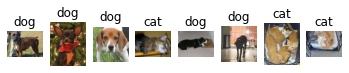

In [5]:
i = 0
fig, ax = plt.subplots(1, 8)
for image, label in x_train.take(8):
    ax[i].axis('off')
    ax[i].set_title(classNames[label])
    ax[i].imshow(image)
    i += 1

plt.show()

Preparation

In [6]:
def preprocess(img, lbl):
    return tf.image.resize(img, [200, 200]), lbl

x_train = x_train.map(preprocess).batch(32)
x_test = x_test.map(preprocess).batch(32)

for image_batch, labels_batch in x_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32,)


TypeError: only integer scalar arrays can be converted to a scalar index

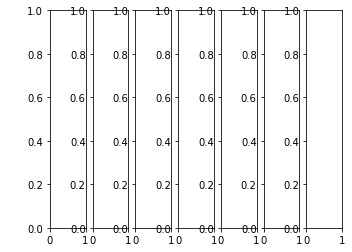

In [53]:
model = keras.models.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(200, 200, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation='softmax')
])

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=["accuracy"])

In [9]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.35, patience=3)
history = model.fit(x_train, validation_data=x_test, epochs=20,
                            callbacks=[ early_stopping, lr_scheduler])

Epoch 1/20
509/509 [==============================] - 24s 45ms/step - loss: 0.6963 - accuracy: 0.5211 - val_loss: 0.6908 - val_accuracy: 0.5335 - lr: 0.0100

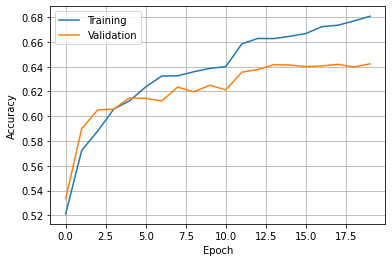

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [11]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 509}

In [12]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

##Evaluate

In [14]:
model.evaluate(x_test)

219/219 [==============================] - 6s 28ms/step - loss: 0.6279 - accuracy: 0.6424

[0.6279392838478088, 0.6423556208610535]

In [54]:
##Save model
model.save('model_learning_rate.h5')